# ***Imports***

In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2
from glob import glob

# Data visualization
import matplotlib.pyplot as plt

# Model
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

# ***Data Loading and Preparation***

Exploring data

In [ ]:
#importing data
all_train_files = glob("Biomedical image segmentation/data/raw/hyper-kvasir-segmented-images/segmented-images/images/*.jpg")
train_gt_files = glob("Biomedical image segmentation/data/raw/hyper-kvasir-segmented-images/segmented-images/masks/*.jpg")
train_gt_files=list(train_gt_files)
train_image_files = list(set(all_train_files) - set(train_gt_files))

Loading data

In [ ]:
#Processing data for model training
# ( I used 'i' because cv2 is taking more time then usual to load images so i used it to track images and it works consistently after that. )

def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(arr,size):
  t=[]
  i=0
  for path in sorted(arr):
    i+=1
    img=load_image(path,size)

    t.append(img)
    print(i)
  return np.array(t)


size = 128   # image size: 128x128

X = load_data(train_image_files, size)
y=load_data(train_gt_files,size)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# ***EDA***

In [ ]:
#data visualization
fig, ax = plt.subplots(5,3, figsize=(10,18))
i = np.random.randint(0,999)

for i in range(5):
    ax[i,0].imshow(X_[i], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y[i], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
    ax[i,2].set_title('Union')
fig.suptitle('Dataset', fontsize=16)
plt.show()

# ***Data Pre-Processing***

In [ ]:
print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (1000, 128, 128)     |  y shape: (1000, 128, 128)

X shape: (1000, 128, 128, 1)  |  y shape: (1000, 128, 128, 1)


Train-test split

In [ ]:
#spiliting dataset for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (800, 128, 128, 1)
y_train shape: (800, 128, 128, 1)
X_test shape: (200, 128, 128, 1)
y_test shape: (200, 128, 128, 1)


Image Augmentation

In [ ]:
#Data Augmentation
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True

                     )

mask_data_gen_args = dict(
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)

batch_size= 32

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


In [ ]:
#Visualizing Augmented Images
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

# ***Modeling***

Builiding U-Net Architecture

Conv block

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

Encoder block

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conmv, pool

Decoder block

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [ ]:
if tf.test.is_gpu_available():
    print("GPU(s) are available and TensorFlow is using them.")
else:
    print("GPU(s) are not available.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU(s) are available and TensorFlow is using them.


Loss Function


In [ ]:
#Dice and IoU loss fucntion

def DiceLoss(targets, inputs, smooth=1e-6):

  #inputs = K.flatten(inputs)
  #targets = K.flatten(targets)
  targets = K.batch_flatten(targets)
  inputs = K.batch_flatten(inputs)

  intersection = K.sum(targets * inputs, axis=-1)
  #intersection = K.sum(targets * inputs)
  dice = (2 * intersection + smooth) / (K.sum(targets, axis=-1) + K.sum(inputs, axis=-1) + smooth)
  return 1 - dice

def IoULoss(targets, inputs, smooth=1e-6):
  targets = K.batch_flatten(targets)
  inputs = K.batch_flatten(inputs)

  intersection = K.sum(targets * inputs, axis=-1)
  union = K.sum(targets) + K.sum(inputs) - intersection


  IoU = (intersection + smooth) / (union + smooth)
  return 1 - IoU


Build model

In [ ]:
#Unet Model
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])

Model plotting

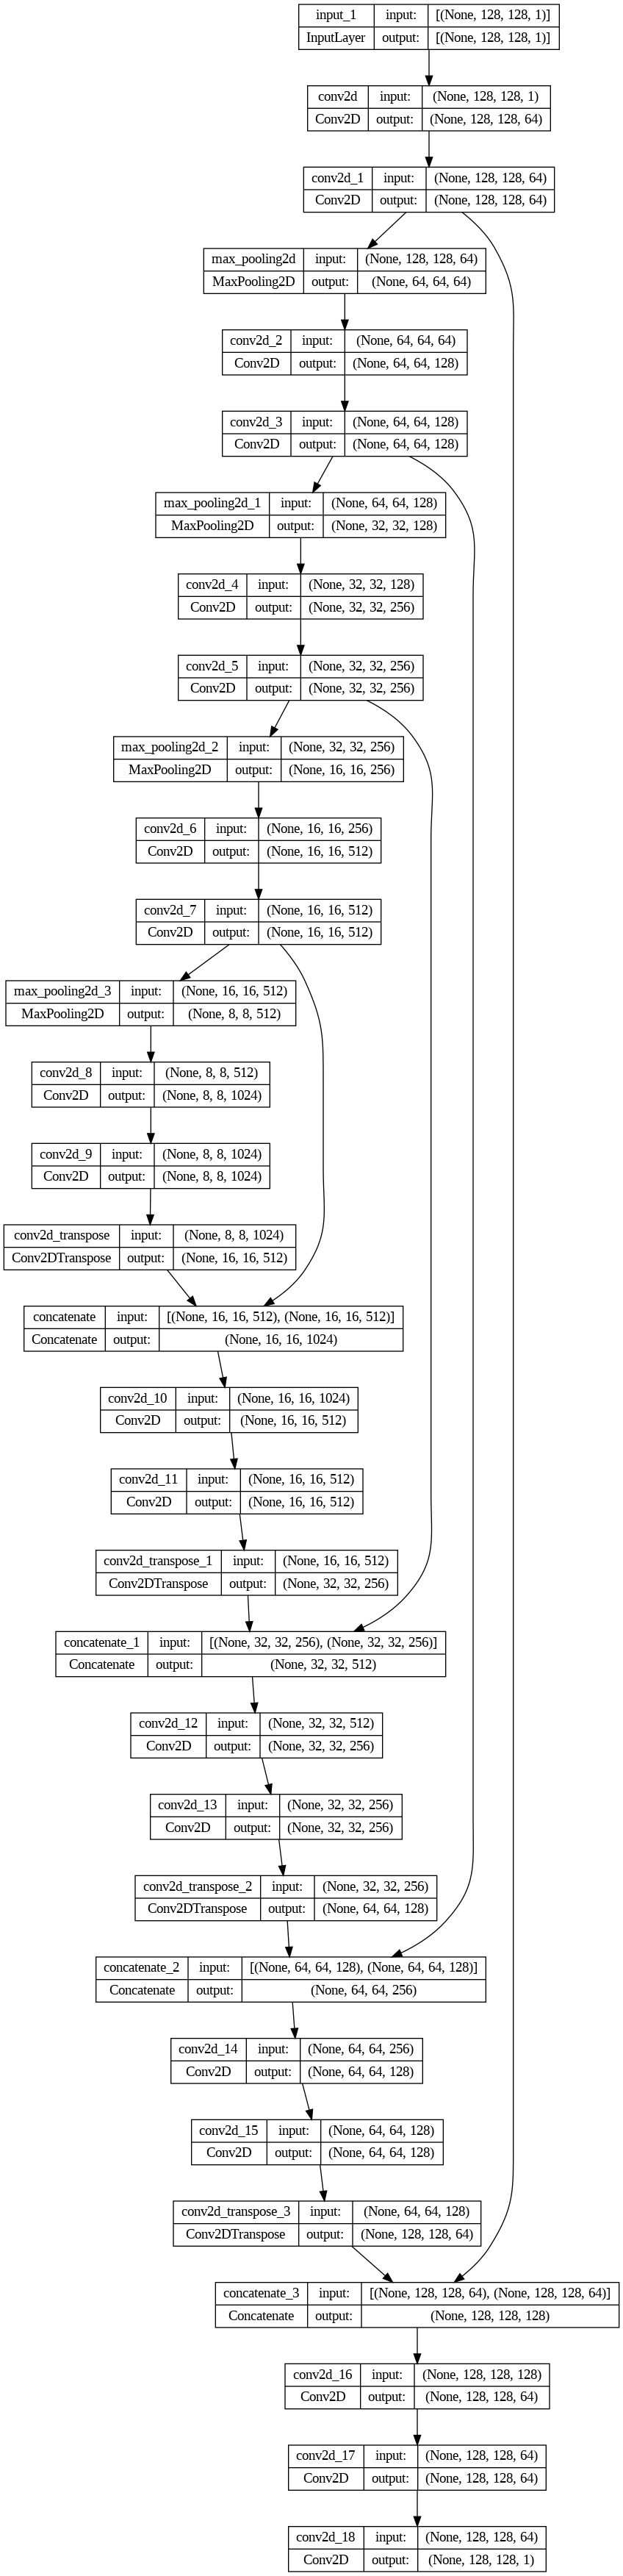

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Model summary

In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# ***Training***

In [ ]:
steps_per_epoch = 3*(len(X_train))//batch_size

In [ ]:
history = model.fit(my_generator, epochs = 100, validation_data = validation_datagen, steps_per_epoch=steps_per_epoch,validation_steps=steps_per_epoch)

Epoch 1/100
75/75 [==============================] - 49s 493ms/step - loss: 0.6968 - accuracy: 0.4552 - val_loss: 0.9408 - val_accuracy: 0.8219
Epoch 2/100
75/75 [==============================] - 37s 500ms/step - loss: 0.6757 - accuracy: 0.5210 - val_loss: 0.6548 - val_accuracy: 0.5339
Epoch 3/100
75/75 [==============================] - 35s 473ms/step - loss: 0.6159 - accuracy: 0.6811 - val_loss: 0.5798 - val_accuracy: 0.7485
Epoch 4/100
75/75 [==============================] - 34s 460ms/step - loss: 0.5812 - accuracy: 0.7550 - val_loss: 0.5696 - val_accuracy: 0.7759
Epoch 5/100
75/75 [==============================] - 35s 469ms/step - loss: 0.5771 - accuracy: 0.7633 - val_loss: 0.5823 - val_accuracy: 0.7958
Epoch 6/100
75/75 [==============================] - 36s 480ms/step - loss: 0.5728 - accuracy: 0.7625 - val_loss: 0.5714 - val_accuracy: 0.7383
Epoch 7/100
75/75 [==============================] - 35s 470ms/step - loss: 0.5719 - accuracy: 0.7593 - val_loss: 0.5635 - val_accuracy:

KeyboardInterrupt: ignored

Importing Model

In [ ]:
from tensorflow.keras.models import load_model

# When loading the model, specify the custom_objects dictionary with 'DiceLoss'
model = load_model('/content/drive/MyDrive/Colab Notebooks/segmented/model.h5', custom_objects={'DiceLoss': DiceLoss})


In [ ]:
learning_rate=0.0001

In [ ]:
model.compile(loss=[DiceLoss], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

In [ ]:
history = model.fit(my_generator, epochs = 50, validation_data = validation_datagen, steps_per_epoch=steps_per_epoch,validation_steps=steps_per_epoch)

Epoch 1/50
75/75 [==============================] - 46s 506ms/step - loss: 0.0474 - accuracy: 0.9652 - val_loss: 0.0750 - val_accuracy: 0.9594
Epoch 2/50
75/75 [==============================] - 36s 488ms/step - loss: 0.0481 - accuracy: 0.9651 - val_loss: 0.0724 - val_accuracy: 0.9593
Epoch 3/50
75/75 [==============================] - 38s 505ms/step - loss: 0.0472 - accuracy: 0.9656 - val_loss: 0.0727 - val_accuracy: 0.9593
Epoch 4/50
75/75 [==============================] - 38s 507ms/step - loss: 0.0473 - accuracy: 0.9650 - val_loss: 0.0734 - val_accuracy: 0.9592
Epoch 5/50
75/75 [==============================] - 37s 488ms/step - loss: 0.0468 - accuracy: 0.9654 - val_loss: 0.0725 - val_accuracy: 0.9596
Epoch 6/50
75/75 [==============================] - 38s 505ms/step - loss: 0.0479 - accuracy: 0.9655 - val_loss: 0.0756 - val_accuracy: 0.9591
Epoch 7/50
75/75 [==============================] - 36s 486ms/step - loss: 0.0461 - accuracy: 0.9648 - val_loss: 0.0742 - val_accuracy: 0.9590

KeyboardInterrupt: ignored

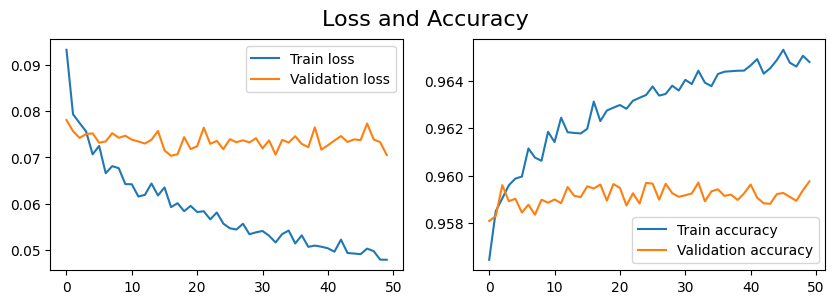

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

# ***Evaluation***

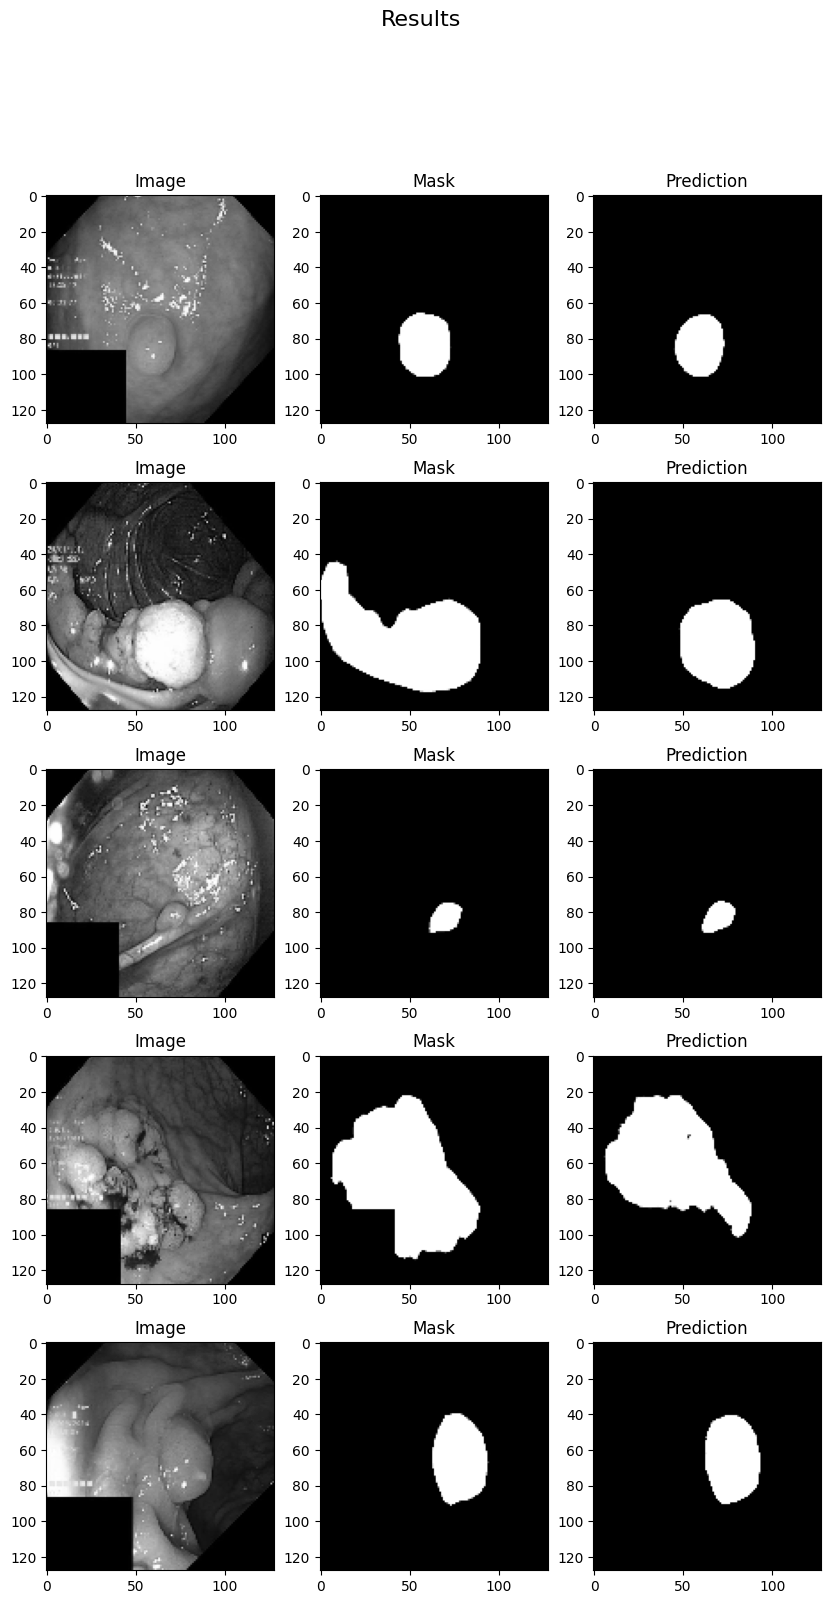

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = BinaryAccuracy()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('BinaryAccuracy = %.3f' % p)

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.926379
BinaryAccuracy = 0.983
Precision Score = 0.953
Recall Score = 0.938
F1 Score = 0.945
